In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

base_path = "/content/drive/MyDrive/Project /Intrenship/DataSets/Data"
print(os.listdir(base_path))


['features_30_sec.csv', 'features_3_sec.csv', 'genres_original', 'images_original']


## Libraries

In [26]:
# ============================
# 📦 All required libraries
# ============================

# Drive / file management
from google.colab import drive
import os, glob, pprint

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Audio processing
import librosa
import librosa.display
from IPython.display import Audio, display

# Image handling
import cv2

# Scikit-learn ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Utility
import warnings
warnings.filterwarnings("ignore")

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [30]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, pprint
drive_root = "/content/drive/MyDrive"
print("Searching Drive root:", drive_root)

Mounted at /content/drive
Searching Drive root: /content/drive/MyDrive


## Utility: recursive search for target names under Drive root

In [31]:
def find_path_named(name_list, root=drive_root, max_results=10):
    matches = {}
    for root_dir, dirs, files in os.walk(root):
        for name in name_list:
            if name in dirs or name in files:
                path = os.path.join(root_dir, name)
                if name not in matches:
                    matches[name] = []
                matches[name].append(path)
                if len(matches[name]) >= max_results:
                    break
    return matches

## Names we want to find

In [32]:
targets = ["features_30_sec.csv", "features_3_sec.csv", "genres_original", "images_original"]
found = find_path_named(targets, root=drive_root, max_results=20)
pprint.pprint(found)

{'features_30_sec.csv': ['/content/drive/MyDrive/Project '
                         '/Intrenship/DataSets/Data/features_30_sec.csv'],
 'features_3_sec.csv': ['/content/drive/MyDrive/Project '
                        '/Intrenship/DataSets/Data/features_3_sec.csv'],
 'genres_original': ['/content/drive/MyDrive/Project '
                     '/Intrenship/DataSets/Data/genres_original'],
 'images_original': ['/content/drive/MyDrive/Project '
                     '/Intrenship/DataSets/Data/images_original']}


## Heuristics to pick base dataset folder

In [33]:
# Priority: use folder that contains 'genres_original' and 'images_original' together
genres_paths = found.get("genres_original", [])
images_paths = found.get("images_original", [])
csv30_paths = found.get("features_30_sec.csv", [])
csv3_paths = found.get("features_3_sec.csv", [])

## Choose a sensible base path

In [34]:
base_candidate = None
if genres_paths:
    base_candidate = os.path.dirname(genres_paths[0])
elif csv30_paths:
    base_candidate = os.path.dirname(csv30_paths[0])
elif csv3_paths:
    base_candidate = os.path.dirname(csv3_paths[0])
elif images_paths:
    base_candidate = os.path.dirname(images_paths[0])

if base_candidate is None:
    raise FileNotFoundError("Could not locate GTZAN files under Drive. Upload dataset or adjust location.")

print("Using base candidate path:", base_candidate)

Using base candidate path: /content/drive/MyDrive/Project /Intrenship/DataSets/Data


## Construct expected locations   

In [35]:
FEATURES_30_CSV = os.path.join(base_candidate, "features_30_sec.csv")
FEATURES_3_CSV  = os.path.join(base_candidate, "features_3_sec.csv")
GENRES_DIR      = os.path.join(base_candidate, "genres_original")
IMAGES_DIR      = os.path.join(base_candidate, "images_original")

In [36]:
print("Paths chosen:")
print(" FEATURES_30_CSV:", FEATURES_30_CSV, "exists?", os.path.exists(FEATURES_30_CSV))
print(" FEATURES_3_CSV :", FEATURES_3_CSV,  "exists?", os.path.exists(FEATURES_3_CSV))
print(" GENRES_DIR     :", GENRES_DIR,      "exists?", os.path.exists(GENRES_DIR))
print(" IMAGES_DIR     :", IMAGES_DIR,      "exists?", os.path.exists(IMAGES_DIR))

Paths chosen:
 FEATURES_30_CSV: /content/drive/MyDrive/Project /Intrenship/DataSets/Data/features_30_sec.csv exists? True
 FEATURES_3_CSV : /content/drive/MyDrive/Project /Intrenship/DataSets/Data/features_3_sec.csv exists? True
 GENRES_DIR     : /content/drive/MyDrive/Project /Intrenship/DataSets/Data/genres_original exists? True
 IMAGES_DIR     : /content/drive/MyDrive/Project /Intrenship/DataSets/Data/images_original exists? True


## 1. Optional: Load precomputed CSVs (if available)

In [37]:
import pandas as pd
csv_30s = None
csv_3s = None

In [38]:
if os.path.exists(FEATURES_30_CSV):
    csv_30s = pd.read_csv(FEATURES_30_CSV)
    print("Loaded features_30_sec.csv ->", csv_30s.shape)
if os.path.exists(FEATURES_3_CSV):
    csv_3s = pd.read_csv(FEATURES_3_CSV)
    print("Loaded features_3_sec.csv ->", csv_3s.shape)

Loaded features_30_sec.csv -> (1000, 60)
Loaded features_3_sec.csv -> (9990, 60)


## 2. Visualizations (use CSVs if present; otherwise prepare from raw)

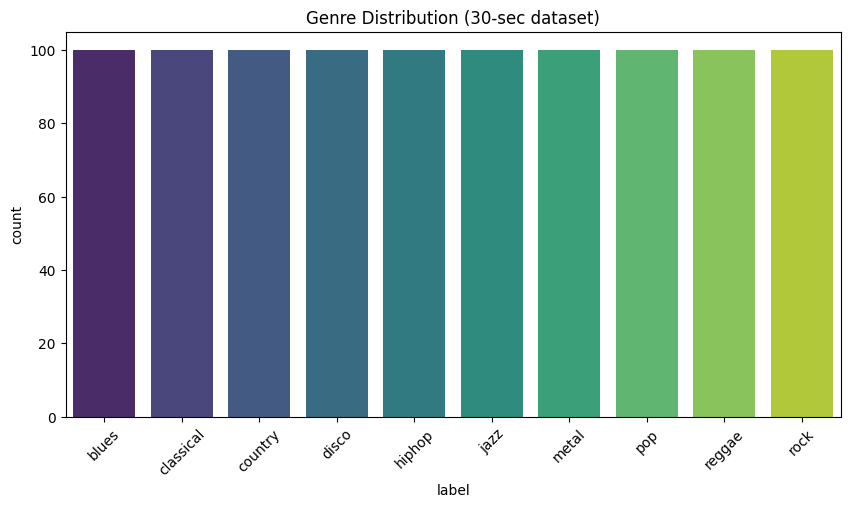

In [39]:
if csv_30s is not None:
    plt.figure(figsize=(10,5))
    sns.countplot(data=csv_30s, x="label", order=csv_30s["label"].value_counts().index, palette="viridis")
    plt.title("Genre Distribution (30-sec dataset)")
    plt.xticks(rotation=45)
    plt.show()

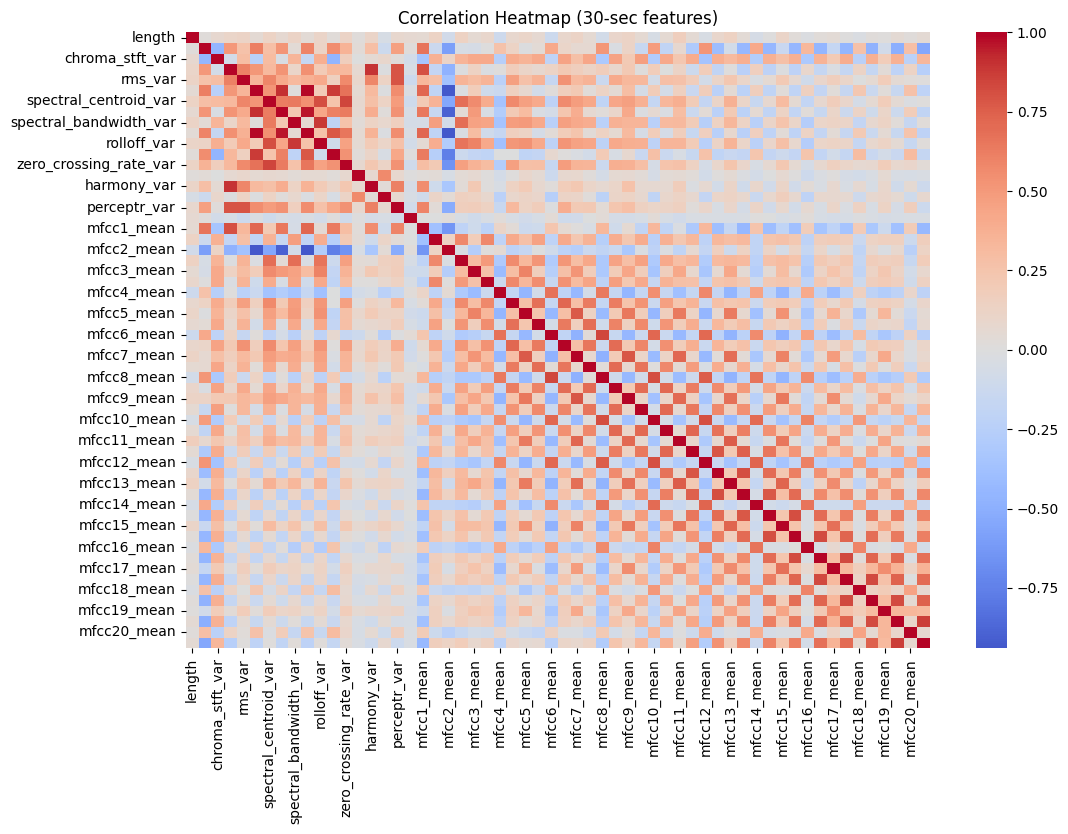

In [41]:
  plt.figure(figsize=(12,8))
  corr_df = csv_30s.drop(columns=[c for c in ["filename","label"] if c in csv_30s.columns])
  sns.heatmap(corr_df.corr(), cmap="coolwarm", center=0)
  plt.title("Correlation Heatmap (30-sec features)")
  plt.show()

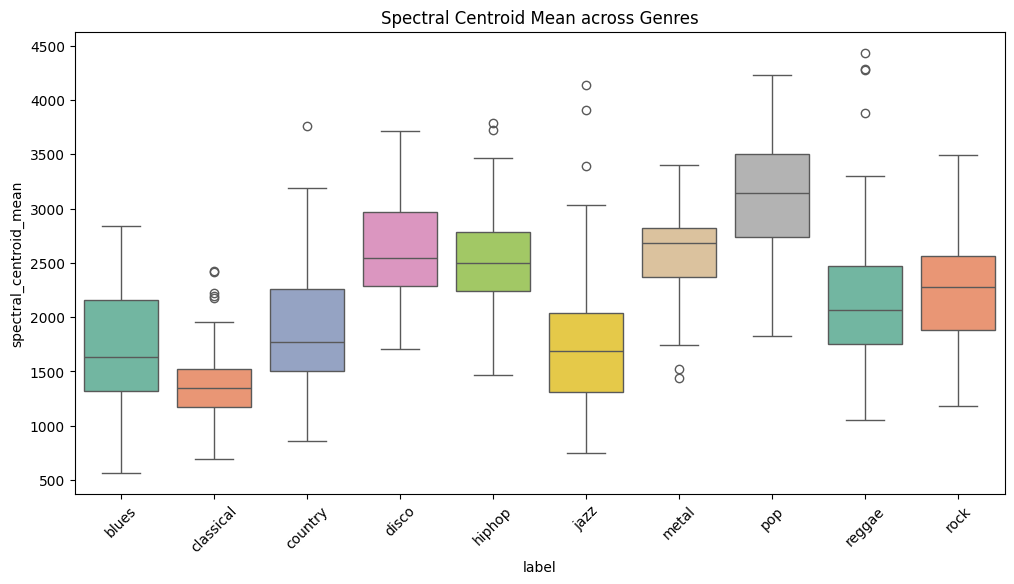

In [42]:
 if "spectral_centroid_mean" in csv_30s.columns:
        plt.figure(figsize=(12,6))
        sns.boxplot(data=csv_30s, x="label", y="spectral_centroid_mean", palette="Set2")
        plt.title("Spectral Centroid Mean across Genres")
        plt.xticks(rotation=45)
        plt.show()

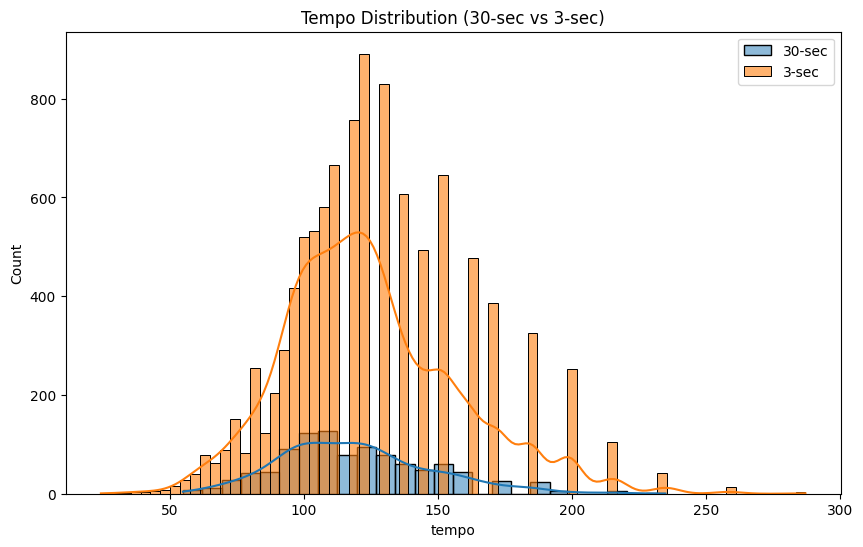

In [43]:
if csv_30s is not None and csv_3s is not None:
    plt.figure(figsize=(10,6))
    if "tempo" in csv_30s.columns and "tempo" in csv_3s.columns:
        sns.histplot(csv_30s["tempo"], kde=True, label="30-sec")
        sns.histplot(csv_3s["tempo"], kde=True, label="3-sec", alpha=0.6)
        plt.legend()
        plt.title("Tempo Distribution (30-sec vs 3-sec)")
        plt.show()

## 3. Quick check inside genres_original (sample audio and spectrogram)

In [44]:
# Detect genres dir
if os.path.exists(GENRES_DIR):
    genres = sorted([d for d in os.listdir(GENRES_DIR) if os.path.isdir(os.path.join(GENRES_DIR, d))])
    print("Genres found:", genres)
    # show counts
    for g in genres:
        files = glob.glob(os.path.join(GENRES_DIR, g, "*"))
        print(g, len(files))
    # pick an example file (first available)
    example_file = None
    for g in genres:
        files = glob.glob(os.path.join(GENRES_DIR, g, "*.wav"))
        if not files:
            files = glob.glob(os.path.join(GENRES_DIR, g, "*.au"))
        if files:
            example_file = files[0]
            break
    if example_file is None:
        print("No audio files found in genres directories (.wav/.au).")
    else:
        print("Example audio file:", example_file)
        y, sr = librosa.load(example_file, sr=22050, duration=30)
        print("Audio shape:", y.shape, "sr:", sr)
        # Waveform
        plt.figure(figsize=(12,4))
        librosa.display.waveshow(y, sr=sr)
        plt.title("Waveform")
        plt.show()
        # Spectrogram (STFT)
        D = np.abs(librosa.stft(y))
        plt.figure(figsize=(12,4))
        librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr, x_axis="time", y_axis="log", cmap="magma")
        plt.title("Spectrogram (dB)")
        plt.colorbar(format="%+2.0f dB")
        plt.show()
        # Mel Spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_db = librosa.power_to_db(S, ref=np.max)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="mel", cmap="viridis")
        plt.title("Mel Spectrogram")
        plt.colorbar(format="%+2.0f dB")
        plt.show()
        # MFCC
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(mfccs, x_axis="time", sr=sr, cmap="coolwarm")
        plt.title("MFCC")
        plt.colorbar()
        plt.show()
        display(Audio(example_file))

else:
    print("genres_original folder not found at:", GENRES_DIR)

Output hidden; open in https://colab.research.google.com to view.

## 4. Tabular approach: use features_3_sec.csv if available (preferred), else compute MFCCs from raw

In [48]:
use_csv3 = (csv_3s is not None)
if use_csv3:
    df = csv_3s.copy()
    print("Using features_3_sec.csv with shape:", df.shape)
    X = df.drop(columns=["filename","label"])
    y = df["label"]
else:
    # Compute MFCC mean+var per file or per 3-sec slice if you prefer segmentation
    print("features_3_sec.csv not found; computing MFCC mean/var from raw audio (may be slow).")
    # We'll process each file once (30s) to compute mean/var MFCC. If many files, limit for quick runs.
    def extract_mfcc_stats(path, n_mfcc=20, sr=22050, duration=30):
        try:
            y, sr = librosa.load(path, sr=sr, duration=duration)
        except Exception as e:
            # try audioread fallback (librosa often uses audioread automatically)
            print("librosa load failed for", path, ":", e)
            return None
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        feats = np.hstack([mfcc.mean(axis=1), mfcc.var(axis=1)])
        return feats

    X_list, y_list = [], []
    if os.path.exists(GENRES_DIR):
        genre_folders = sorted([d for d in os.listdir(GENRES_DIR) if os.path.isdir(os.path.join(GENRES_DIR, d))])
        # Quick-run limit: set samples_per_genre = None for full dataset or e.g. 30 for faster runs
        samples_per_genre = None  # set to an integer for quick runs (e.g., 30)
        for g in genre_folders:
            files = glob.glob(os.path.join(GENRES_DIR, g, "*.wav"))
            if len(files) == 0:
                files = glob.glob(os.path.join(GENRES_DIR, g, "*.au"))
            if samples_per_genre:
                files = files[:samples_per_genre]
            print(f"Processing {len(files)} files for genre {g}")
            for f in files:
                feats = extract_mfcc_stats(f, n_mfcc=20)
                if feats is not None:
                    X_list.append(feats)
                    y_list.append(g)
    X = pd.DataFrame(X_list)
    y = pd.Series(y_list)
    print("Computed table shape:", X.shape, y.shape)

Using features_3_sec.csv with shape: (9990, 60)


## Encode / scale / split

In [49]:
le = LabelEncoder()
y_enc = le.fit_transform(y)
X_vals = np.array(X, dtype=float)
scaler = StandardScaler().fit(X_vals)
X_scaled = scaler.transform(X_vals)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, stratify=y_enc, test_size=0.2, random_state=42)
print("Tabular shapes:", X_train.shape, X_test.shape)


Tabular shapes: (7992, 58) (1998, 58)


## RandomForest baseline

In [50]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("RandomForest classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


RandomForest classification report:
              precision    recall  f1-score   support

       blues       0.86      0.87      0.87       200
   classical       0.91      0.96      0.93       199
     country       0.80      0.83      0.82       199
       disco       0.82      0.84      0.83       200
      hiphop       0.92      0.89      0.91       200
        jazz       0.85      0.90      0.87       200
       metal       0.87      0.94      0.90       200
         pop       0.97      0.82      0.89       200
      reggae       0.83      0.89      0.86       200
        rock       0.88      0.72      0.79       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



## Confusion matrix plot

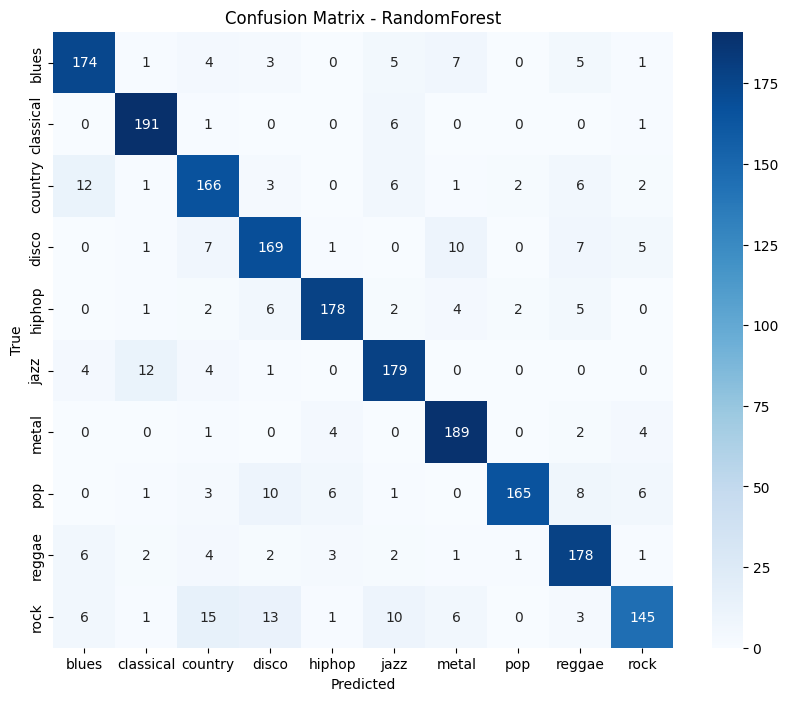

In [51]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix - RandomForest")
plt.show()

## 5. Tabular: MLP (Keras)

In [52]:
num_classes = len(le.classes_)
mlp = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_mlp = mlp.fit(X_train, y_train, validation_split=0.1, epochs=25, batch_size=32)

Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3991 - loss: 1.6826 - val_accuracy: 0.6950 - val_loss: 0.9311
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6373 - loss: 1.0324 - val_accuracy: 0.7450 - val_loss: 0.7857
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7047 - loss: 0.8643 - val_accuracy: 0.7688 - val_loss: 0.6847
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7322 - loss: 0.7604 - val_accuracy: 0.7862 - val_loss: 0.6340
Epoch 5/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7609 - loss: 0.6938 - val_accuracy: 0.8012 - val_loss: 0.5908
Epoch 6/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7783 - loss: 0.6429 - val_accuracy: 0.8338 - val_loss: 0.5255
Epoch 7/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7969 - loss: 0.6040 - val_accuracy: 0.8275 - val_loss: 0.5039
Epoch 8/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8053 - loss: 0.5598 - val_accuracy: 0

#
# Evaluate

In [53]:
y_pred_mlp = np.argmax(mlp.predict(X_test), axis=1)
print("MLP classification report:")
print(classification_report(y_test, y_pred_mlp, target_names=le.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MLP classification report:
              precision    recall  f1-score   support

       blues       0.84      0.92      0.88       200
   classical       0.94      0.95      0.94       199
     country       0.86      0.79      0.83       199
       disco       0.82      0.88      0.85       200
      hiphop       0.89      0.87      0.88       200
        jazz       0.84      0.93      0.88       200
       metal       0.92      0.95      0.93       200
         pop       0.90      0.82      0.86       200
      reggae       0.83      0.89      0.86       200
        rock       0.91      0.72      0.81       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



## Plot MLP training curves

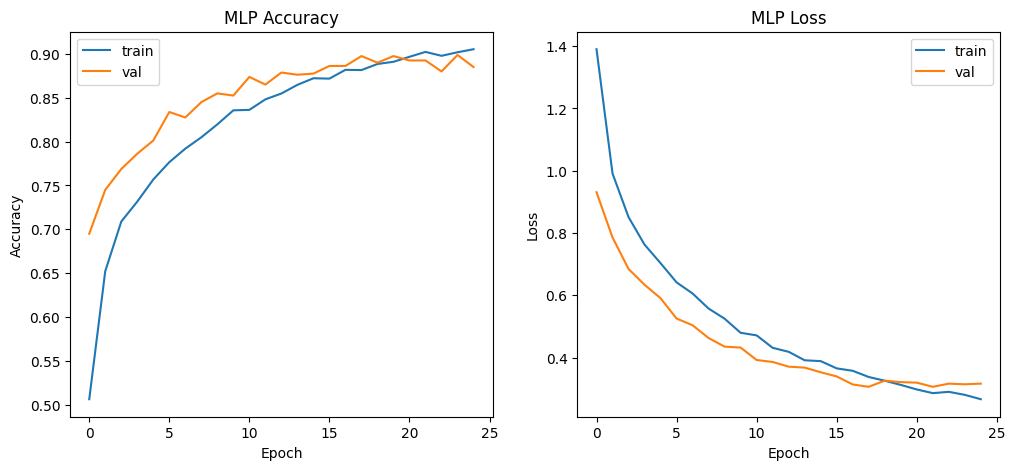

In [54]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_mlp.history['accuracy'], label='train')
plt.plot(history_mlp.history['val_accuracy'], label='val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('MLP Accuracy')
plt.subplot(1,2,2)
plt.plot(history_mlp.history['loss'], label='train')
plt.plot(history_mlp.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('MLP Loss')
plt.show()

## 6. Image approach: build mel-spectrogram dataset (images)

In [55]:
def make_mel_image(path, n_mels=128, sr=22050, duration=30, img_size=(128,128), max_pad_len=128):
    try:
        y, sr = librosa.load(path, sr=sr, duration=duration)
    except:
        return None
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    # pad or crop time axis to max_pad_len frames
    if S_db.shape[1] < max_pad_len:
        pad_width = max_pad_len - S_db.shape[1]
        S_db = np.pad(S_db, ((0,0),(0,pad_width)), mode='constant')
    else:
        S_db = S_db[:, :max_pad_len]
    # normalize 0-1
    img = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-8)
    img = cv2.resize(img, img_size)
    return img

## Build image dataset by scanning genres_original

In [56]:
X_img_list, y_img_list = [], []
if os.path.exists(GENRES_DIR):
    genres = sorted([d for d in os.listdir(GENRES_DIR) if os.path.isdir(os.path.join(GENRES_DIR, d))])
    # QUICK-RUN: limit per genre for speed; set to None or >100 for full dataset
    samples_per_genre = 100   # change to None to use all files
    for g in genres:
        files = glob.glob(os.path.join(GENRES_DIR, g, "*.wav"))
        if len(files)==0:
            files = glob.glob(os.path.join(GENRES_DIR, g, "*.au"))
        if samples_per_genre:
            files = files[:samples_per_genre]
        print(f"Converting {len(files)} audio files to mel images for genre {g}")
        for f in files:
            img = make_mel_image(f, img_size=(128,128))
            if img is not None:
                X_img_list.append(img)
                y_img_list.append(g)
else:
    print("No genres_original folder found for image creation.")


Converting 100 audio files to mel images for genre blues
Converting 100 audio files to mel images for genre classical
Converting 100 audio files to mel images for genre country
Converting 100 audio files to mel images for genre disco
Converting 100 audio files to mel images for genre hiphop
Converting 100 audio files to mel images for genre jazz
Converting 100 audio files to mel images for genre metal
Converting 100 audio files to mel images for genre pop
Converting 100 audio files to mel images for genre reggae
Converting 100 audio files to mel images for genre rock


In [57]:
X_img = np.array(X_img_list)
y_img = np.array(y_img_list)
print("Image dataset shape:", X_img.shape, y_img.shape)

Image dataset shape: (999, 128, 128) (999,)


## Show sample spectrogram images (same visualization as you had)

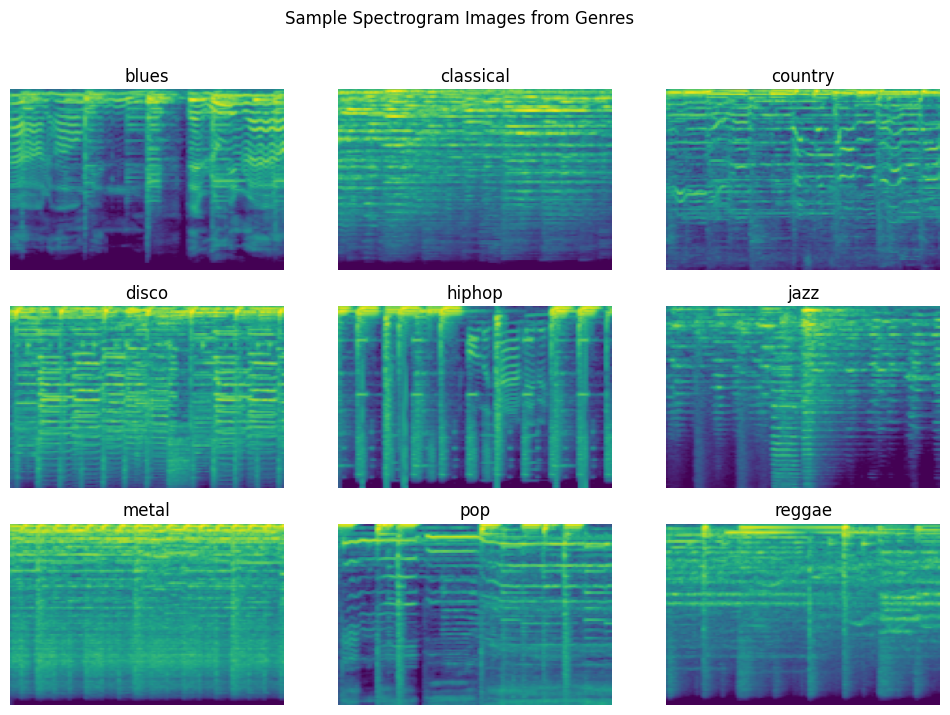

In [58]:
if X_img.shape[0] > 0:
    plt.figure(figsize=(12,8))
    unique_genres = sorted(list(set(y_img)))
    for i, g in enumerate(unique_genres[:9]):
        idx = np.where(y_img == g)[0][0]
        plt.subplot(3,3,i+1)
        plt.imshow(X_img[idx], aspect='auto')
        plt.title(g)
        plt.axis('off')
    plt.suptitle("Sample Spectrogram Images from Genres")
    plt.show()

## 7. Train CNN from scratch on spectrogram images

In [59]:
if X_img.shape[0] > 0:
    # Prepare data
    # Normalize and expand channel to 3 for consistency with transfer models
    X_img_norm = X_img[..., np.newaxis]  # shape (N, H, W, 1)
    # Optionally repeat to 3 channels: X_img_rgb = np.repeat(X_img_norm, 3, axis=-1)
    # Encode labels
    le_img = LabelEncoder()
    y_img_enc = le_img.fit_transform(y_img)

    Xtr_img, Xte_img, ytr_img, yte_img = train_test_split(X_img_norm, y_img_enc, stratify=y_img_enc, test_size=0.2, random_state=42)
    print("Image train/test shapes:", Xtr_img.shape, Xte_img.shape)


Image train/test shapes: (799, 128, 128, 1) (200, 128, 128, 1)


### Build small CNN (expects channel-last with 1 channel)

In [62]:
cnn = models.Sequential([
    layers.Input(shape=Xtr_img.shape[1:]),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le_img.classes_), activation='softmax')
])

cnn.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

history_cnn = cnn.fit(
    Xtr_img, ytr_img,
    validation_split=0.15,
    epochs=20,
    batch_size=32
)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 0.1064 - loss: 2.3078 - val_accuracy: 0.1833 - val_loss: 2.2997
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1859 - loss: 2.2805 - val_accuracy: 0.0833 - val_loss: 2.2898
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1689 - loss: 2.2134 - val_accuracy: 0.1750 - val_loss: 2.1992
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2108 - loss: 2.1326 - val_accuracy: 0.1750 - val_loss: 2.1993
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2307 - loss: 2.1008 - val_accuracy: 0.1583 - val_loss: 2.1789
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2123 - loss: 2.0516 - val_accuracy: 0.1667 - val_loss: 2.0999
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2344 - loss: 2.0132 - val_accuracy: 0.2250 - val_loss: 2.1691
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2552 - loss: 2.0279 - val_accuracy: 0.2500 -

In [65]:
# Evaluate CNN
y_pred_cnn = np.argmax(cnn.predict(Xte_img), axis=1)
print("CNN classification report:")
print(classification_report(yte_img, y_pred_cnn, target_names=le_img.classes_))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
CNN classification report:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        20
   classical       0.46      0.65      0.54        20
     country       0.17      0.10      0.12        20
       disco       0.27      0.35      0.30        20
      hiphop       0.40      0.10      0.16        20
        jazz       0.23      0.60      0.33        20
       metal       0.67      0.80      0.73        20
         pop       0.47      0.35      0.40        20
      reggae       0.46      0.60      0.52        20
        rock       0.42      0.25      0.31        20

    accuracy                           0.38       200
   macro avg       0.35      0.38      0.34       200
weighted avg       0.35      0.38      0.34       200



## Plot CNN training curves

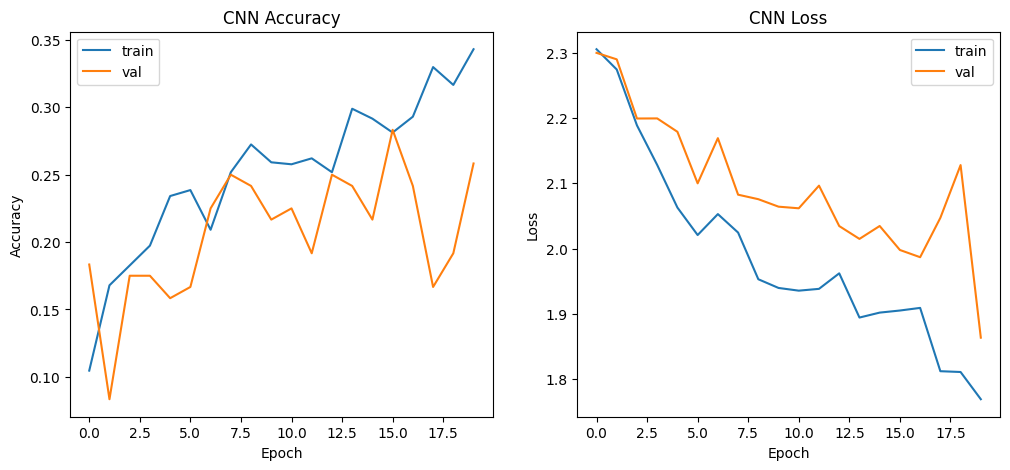

In [67]:

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history_cnn.history['accuracy'], label='train')
    plt.plot(history_cnn.history['val_accuracy'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('CNN Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history_cnn.history['loss'], label='train')
    plt.plot(history_cnn.history['val_loss'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('CNN Loss')
    plt.show()

## 8. Transfer Learning (MobileNetV2) on spectrogram images

In [68]:
if X_img.shape[0] > 0:
    # Convert to 3-channel RGB images by repeating channel
    X_img_rgb = np.repeat(X_img[..., np.newaxis], 3, axis=-1)
    # If MobileNetV2 expects normalized input, we'll rescale in preprocessing step
    Xtr_t, Xte_t, ytr_t, yte_t = train_test_split(X_img_rgb, y_img_enc, stratify=y_img_enc, test_size=0.2, random_state=42)

In [70]:
base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128,128,3))
base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [72]:
    inp = layers.Input(shape=(128,128,3))
    x = preprocess_input(inp)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(len(le_img.classes_), activation='softmax')(x)
    tl_model = models.Model(inp, out)


In [73]:
tl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_tl = tl_model.fit(Xtr_t, ytr_t, validation_split=0.15, epochs=15, batch_size=32)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.0973 - loss: 2.6563 - val_accuracy: 0.0750 - val_loss: 2.4531
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.1017 - loss: 2.5872 - val_accuracy: 0.0917 - val_loss: 2.3342
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1034 - loss: 2.5037 - val_accuracy: 0.1750 - val_loss: 2.2852
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1032 - loss: 2.5228 - val_accuracy: 0.2000 - val_loss: 2.2938
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1242 - loss: 2.5137 - val_accuracy: 0.1083 - val_loss: 2.3600
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1007 - loss: 2.5235 - val_accuracy: 0.1083 - val_loss: 2.2972
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1067 - loss: 2.4613 - val_accuracy: 0.1000 - val_loss: 2.2890
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1357 - loss: 2.3833 - val_accuracy: 0.0917 - v

## Evaluate

In [74]:
y_pred_tl = np.argmax(tl_model.predict(Xte_t), axis=1)
print("Transfer-learning (MobileNetV2) classification report:")
print(classification_report(yte_t, y_pred_tl, target_names=le_img.classes_))

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
Transfer-learning (MobileNetV2) classification report:
              precision    recall  f1-score   support

       blues       0.46      0.55      0.50        20
   classical       0.00      0.00      0.00        20
     country       0.00      0.00      0.00        20
       disco       0.13      0.35      0.19        20
      hiphop       0.00      0.00      0.00        20
        jazz       0.21      0.80      0.33        20
       metal       0.39      0.90      0.55        20
         pop       0.00      0.00      0.00        20
      reggae       0.00      0.00      0.00        20
        rock       0.00      0.00      0.00        20

    accuracy                           0.26       200
   macro avg       0.12      0.26      0.16       200
weighted avg       0.12      0.26      0.16       200



## Plot TL training curves

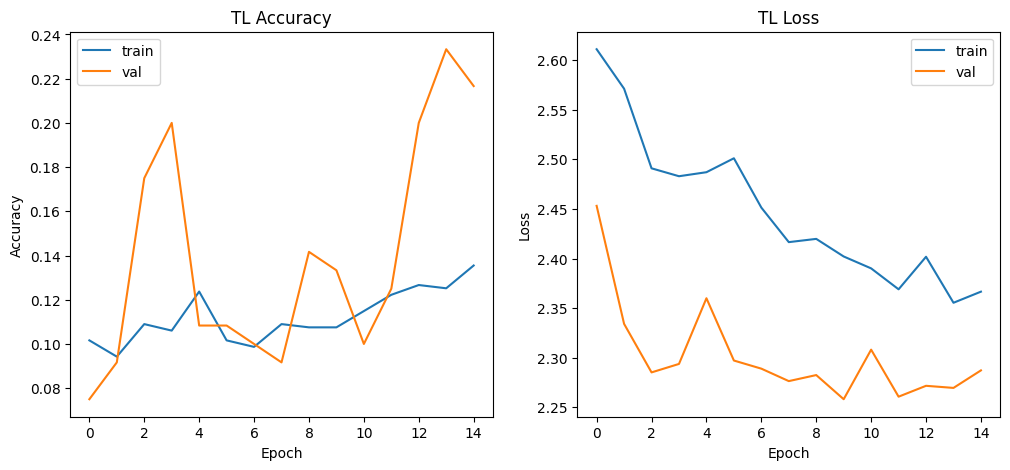

In [75]:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history_tl.history['accuracy'], label='train')
    plt.plot(history_tl.history['val_accuracy'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('TL Accuracy')
    plt.subplot(1,2,2)
    plt.plot(history_tl.history['loss'], label='train')
    plt.plot(history_tl.history['val_loss'], label='val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('TL Loss')
    plt.show()

## 9. Summary table & final plots

In [76]:
print("Done. Summary:")
print(" - Tabular used CSV (3s)?:", use_csv3)
print(" - Tabular X shape:", X.shape if 'X' in locals() else None)
if X_img.shape[0] > 0:
    print(" - Image dataset shape:", X_img.shape, "labels:", len(set(y_img)))
else:
    print(" - No image dataset created (no audio files found).")

Done. Summary:
 - Tabular used CSV (3s)?: True
 - Tabular X shape: (9990, 58)
 - Image dataset shape: (999, 128, 128) labels: 10
